X_train (1738, 360) y_train (1738, 120)
Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.5905 - val_loss: 0.4642 - learning_rate: 0.0010
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4672 - val_loss: 0.4519 - learning_rate: 0.0010
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4436 - val_loss: 0.4445 - learning_rate: 0.0010
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4309 - val_loss: 0.4541 - learning_rate: 0.0010
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4198 - val_loss: 0.4436 - learning_rate: 0.0010
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4099 - val_loss: 0.4560 - learning_rate: 0.0010
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3993 - val_loss: 0.4606 - learning_rate: 0.0010
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3909 - val_loss: 0.4709 - learning_rate: 0.0010
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3806 - val_loss: 0.4789 

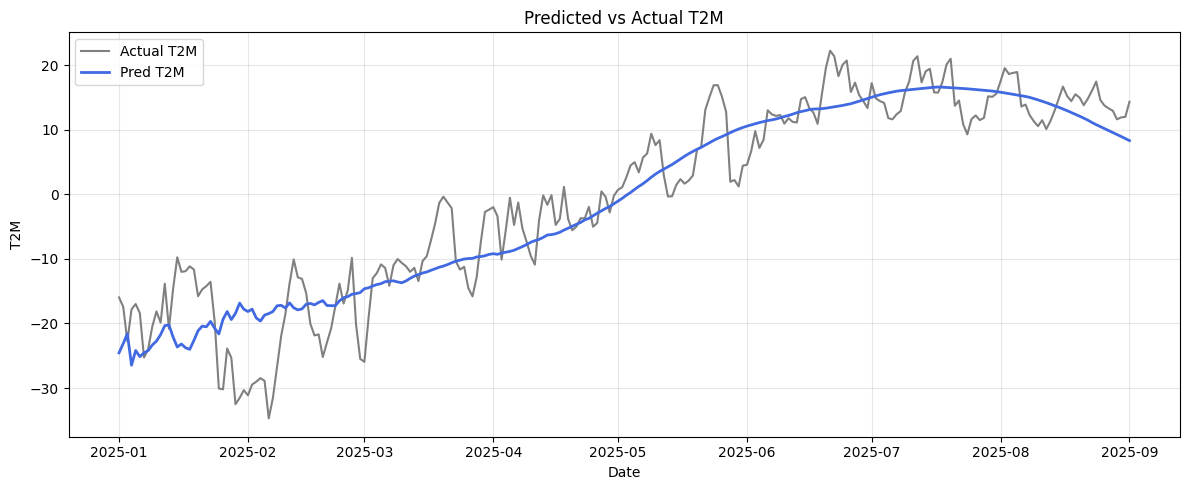

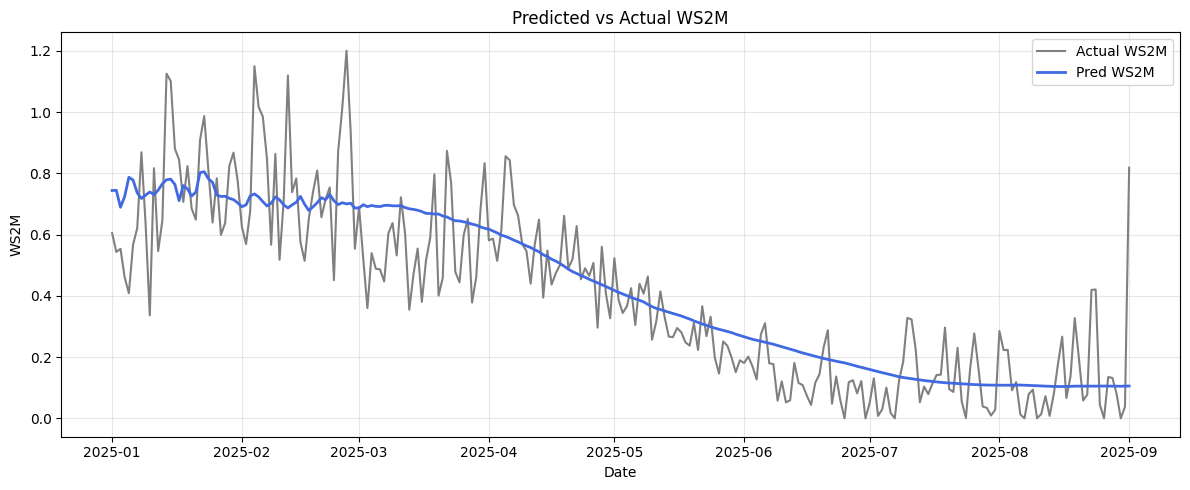

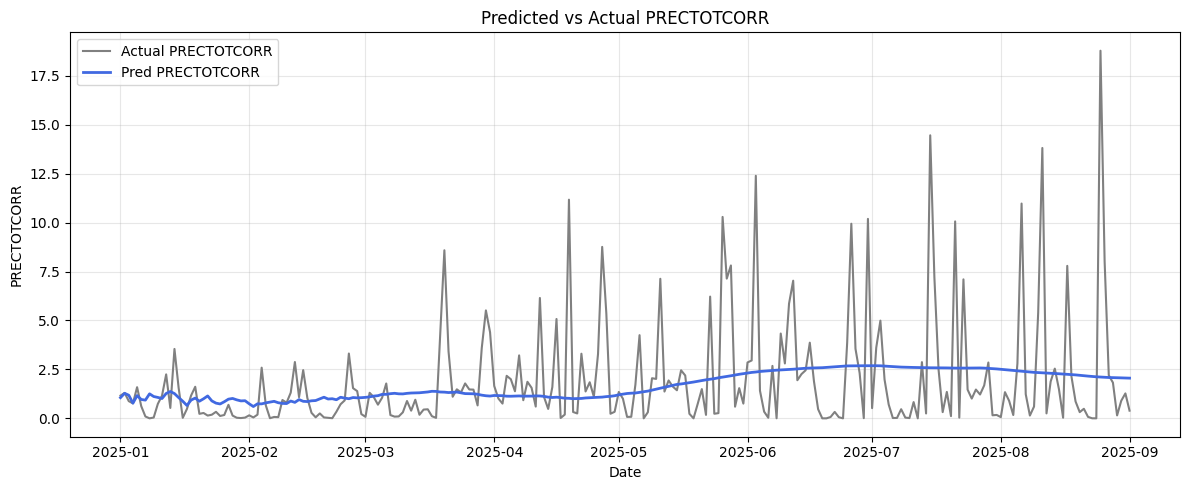

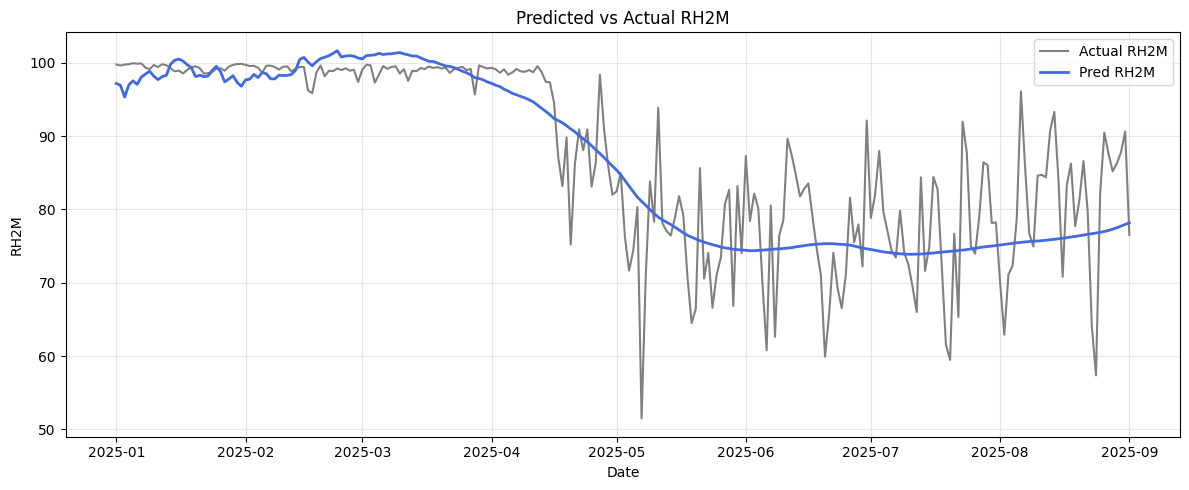

In [9]:
#The use of Chat GPT is acknowledged in the preparation of this code; Fixing errors and improving efficiency of the ML model code
#Code by Chris Ahouzi, University of Toronto
#Made on  05/10/2025, for Nasa Space Apps Challenge 2025. Team: Donkeystadors, Team members: Chris Ahouzi, Jad Mohieldin
#training MLP model to predict weather data
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout, Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#1️ Load and aggregate
csv_path = r"C:\Users\ahouz\OneDrive - University of Toronto\Desktop\hackathon\POWER_Point_Hourly_20200101_20250901_056d00N_106d00E_LST.csv"
df = pd.read_csv(csv_path)
df['date'] = pd.to_datetime(dict(year=df['YEAR'], month=df['MO'], day=df['DY'], hour=df['HR']))
daily = (
    df.groupby(df['date'].dt.date)
      .mean(numeric_only=True)
      .reset_index()
      .rename(columns={'date': 'DAY'})
)
daily['DAY'] = pd.to_datetime(daily['DAY'])

#2️ Add cyclical date features
daily['doy'] = daily['DAY'].dt.dayofyear
daily['sin_doy'] = np.sin(2*np.pi*daily['doy']/365.25)
daily['cos_doy'] = np.cos(2*np.pi*daily['doy']/365.25)

#3️ Train/test split
split_date = pd.Timestamp("2025-01-01")
train_df = daily[daily['DAY'] < split_date].copy()
test_df  = daily[daily['DAY'] >= split_date].copy()

#4️ Scale each target separately
targets = ['T2M', 'WS2M', 'PRECTOTCORR', 'RH2M']
scalers = {}
for col in targets:
    s = StandardScaler()
    train_df[col+'_scaled'] = s.fit_transform(train_df[[col]])
    test_df[col+'_scaled']  = s.transform(test_df[[col]])
    scalers[col] = s

FEATURES = [t+'_scaled' for t in targets] + ['sin_doy','cos_doy']

LOOKBACK_DAYS = 60
HORIZON_DAYS  = 30

#5️ Windowing for multi-target output
def makeXy_multivar_days(df, feats=FEATURES, target_cols=[t+'_scaled' for t in targets],
                         lookback=LOOKBACK_DAYS, horizon=HORIZON_DAYS):
    A = df[feats].values
    X, y = [], []
    for i in range(lookback, len(A) - horizon + 1):
        X.append(A[i - lookback:i, :])
        # flatten all target columns for next horizon days
        y.append(df[target_cols].iloc[i:i+horizon].values.flatten())
    X = np.array(X).reshape(len(X), -1)
    y = np.array(y)
    return X, y

X_train, y_train = makeXy_multivar_days(train_df)
X_test,  y_test  = makeXy_multivar_days(test_df)
print("X_train", X_train.shape, "y_train", y_train.shape)

#6️ Model: same structure, output = HORIZON_DAYS * number of targets
out_dim = HORIZON_DAYS * len(targets)

inp = Input(shape=(X_train.shape[1],))
x = Dense(512, activation='relu')(inp)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(out_dim, activation='linear')(x)
model = Model(inp, out)
model.compile(optimizer='adam', loss='mse')

early  = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

_ = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=32, shuffle=True,
    callbacks=[early, reduce], verbose=1
)

#7️ Autoregressive rollout
def rollout_multitarget(model, scalers, train_df, test_df,
                        feats=FEATURES, targets=targets,
                        lookback=LOOKBACK_DAYS, horizon=HORIZON_DAYS):
    seq = train_df[feats].values[-lookback:].reshape(1, -1)
    n_days = len(test_df)
    preds_scaled = {t: [] for t in targets}
    F = len(feats)
    T = len(targets)

    for i in range(n_days):
        block = model.predict(seq, verbose=0)[0]
        block = block.reshape(horizon, T)
        next_pred = block[0]   # next-day predictions for all variables
        for j, t in enumerate(targets):
            preds_scaled[t].append(next_pred[j])

        # advance date features
        date = test_df['DAY'].iloc[i]
        doy = date.dayofyear
        sin_doy = np.sin(2*np.pi*doy/365.25)
        cos_doy = np.cos(2*np.pi*doy/365.25)

        # build new input row (all predicted variables + sin/cos)
        new_feat = np.concatenate([next_pred, [sin_doy, cos_doy]]).reshape(1, -1)
        seq = np.append(seq[:, F:], new_feat, axis=1)

    # inverse-transform each variable
    results = pd.DataFrame({'Date': test_df['DAY'].reset_index(drop=True)})
    for t in targets:
        arr = np.array(preds_scaled[t]).reshape(-1, 1)
        results['Pred_'+t] = scalers[t].inverse_transform(arr).flatten()
    return results

preds_val_df = rollout_multitarget(model, scalers, train_df, test_df)
print(preds_val_df.head())

#8️ Plot example

for v in ['T2M', 'WS2M','PRECTOTCORR','RH2M']:
    plt.figure(figsize=(12,5))
    plt.plot(test_df['DAY'], test_df[v], 'gray', lw=1.5, label=f'Actual {v}')
    plt.plot(preds_val_df['Date'], preds_val_df['Pred_'+v], 'royalblue', lw=2, label=f'Pred {v}')
    plt.title(f'Predicted vs Actual {v}')
    plt.xlabel('Date'); plt.ylabel(v)
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


In [8]:
#Predicting future weather with LSTM
def forecast_future_multitarget(model, scalers, daily_df,
                                feats=['T2M_scaled','WS2M_scaled','PRECTOTCORR_scaled','RH2M_scaled','sin_doy','cos_doy'],
                                targets=['T2M','WS2M','PRECTOTCORR','RH2M'],
                                lookback=60, horizon_days=int):

    seq = daily_df[feats].values[-lookback:].reshape(1, -1)
    preds_scaled = {t: [] for t in targets}
    F = len(feats)
    T = len(targets)
    last_date = daily_df['DAY'].iloc[-1]

    for i in range(horizon_days):
        # Predict next-day block
        block = model.predict(seq, verbose=0)[0]
        block = block.reshape(-1, T)       # shape (30,4)
        next_pred = block[0]               # use first day only

        # store scaled predictions
        for j, t in enumerate(targets):
            preds_scaled[t].append(next_pred[j])

        # date features for next day
        date = last_date + pd.Timedelta(days=i+1)
        doy = date.dayofyear
        sin_doy = np.sin(2*np.pi*doy/365.25)
        cos_doy = np.cos(2*np.pi*doy/365.25)

        # prepare new row = predicted scaled vars + sin/cos
        new_feat = np.concatenate([next_pred, [sin_doy, cos_doy]]).reshape(1, -1)
        seq = np.append(seq[:, F:], new_feat, axis=1)

    # inverse transform for each target
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                 periods=horizon_days, freq='D')
    results = pd.DataFrame({'Date': future_dates})
    for t in targets:
        arr = np.array(preds_scaled[t]).reshape(-1, 1)
        results['Pred_'+t] = scalers[t].inverse_transform(arr).flatten()

    return results
scalers = {}
for col in ['T2M', 'WS2M', 'PRECTOTCORR', 'RH2M']:
    s = StandardScaler()
    daily[col + '_scaled'] = s.fit_transform(daily[[col]])
    scalers[col] = s
# Ask the user for a date
d = input("What day do you want to forecast from? (YYYYMMDD): ")

# Convert the string to a proper datetime object
target_day = pd.to_datetime(d, format="%Y%m%d")
days_ahead = (target_day - daily['DAY'].iloc[-1]).days

future_df = forecast_future_multitarget(model, scalers, daily,
                                        lookback=60, horizon_days= int(days_ahead))

day_forecast = future_df[future_df['Date'] == target_day]

row = day_forecast.iloc[0]
print(f"\n Weather forecast for {target_day.date()}:\n")
print(f" Temperature (T2M): {row['Pred_T2M']:.2f} °C")
print(f" Wind Speed (WS2M): {row['Pred_WS2M']:.2f} m/s")
print(f" Precipitation (PRECTOTCORR): {row['Pred_PRECTOTCORR']:.2f} mm/day")
print(f" Relative Humidity (RH2M): {row['Pred_RH2M']:.1f}%\n")


 Weather forecast for 2026-01-06:

 Temperature (T2M): -22.15 °C
 Wind Speed (WS2M): 0.62 m/s
 Precipitation (PRECTOTCORR): 1.24 mm/day
 Relative Humidity (RH2M): 96.9%

